In [1]:
from google.colab import files
import numpy as np                    # we will use for mathematical calculation on image
import matplotlib.image as mpimg      # to read the image
import matplotlib.pyplot as plt       # to plot the images
import cv2

%matplotlib inline

In [3]:
uploaded = files.upload()

Saving 20069.jpg to 20069.jpg


<class 'numpy.ndarray'>
(481, 321, 3)


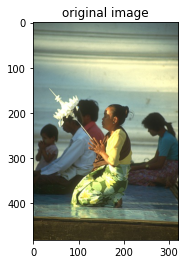

In [4]:
I = mpimg.imread("20069.jpg")       # get the input RGB image for processing
print(type(I))                       # type of input image is numpy 
print(I.shape)                       # shape of the image shows having three channels
plt.title('original image')          # plotting image using plt from matplotlib
plt.imshow(I)                        # showing the input image

(481, 321)


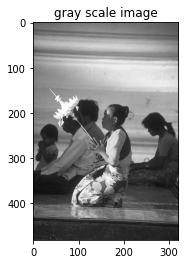

In [5]:
# converting input RGB image to gray scale
[rows,cols,channels] = np.shape(I)

# Split image into seperate r g b channels
r=I[:,:,0]
g=I[:,:,1]
b=I[:,:,2]

# Grey image
Gray_I=r/3+g/3+b/3
plt.title('gray scale image')
plt.imshow(Gray_I, cmap ='gray')  # show the gray scale image 
print(Gray_I.shape)               # shape shows it has only one channel now

In [6]:
# generating a gaussian kernal to remove noise

def gaussian_kernel(size, sigma):                       # size we are using is 3 and sigma = 1.4        
    
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]         # np.mgrid used to create rectagular grid out of two 2 input 1-D arrays
    N = 1 / (2.0 * np.pi * sigma**2)
    G =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * N  # formula to generate gaussian filter
    
    return G

[[0.04875119 0.06291796 0.04875119]
 [0.06291796 0.0812015  0.06291796]
 [0.04875119 0.06291796 0.04875119]]


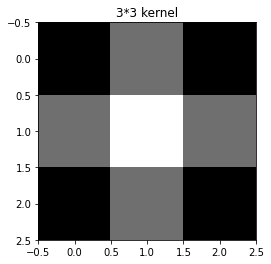

In [7]:
size = 3
sigma = 1.4
G_kernel = gaussian_kernel(size, sigma)               # here size=3 and sigma = 1.4
print(G_kernel)                                       # kernal in array form
plt.title('3*3 kernel')                               # plotting the 3*3 kernel
plt.imshow(G_kernel, cmap = 'gray')

In [8]:
# design of a convolution function for 2D images

def convolution2d(image, kernel, Pd, S=1):        # input image, gaussian kernel, padding, stride size
    
    kernel = np.flipud(np.fliplr(kernel))
    Xk = kernel.shape[0]                          # rows of kernel
    Yk = kernel.shape[1]                          # columns of kernel
    Xi = image.shape[0]                           # rows of image
    Yi = image.shape[1]                           # columns of image
    
     # Shape of Output Convolution
    Xo = int(((Xi - Xk + 2 * Pd) / S) + 1)       
    Yo = int(((Yi - Yk + 2 * Pd) / S) + 1)
    
    out = np.zeros((Xo, Yo))                      # shape of image after convolution
    
    if Pd != 0:
        Ip = np.zeros((image.shape[0] + Pd*2, image.shape[1] + Pd*2))    # adding padding so out image shape remains same
        Ip[int(Pd):int(-1 * Pd), int(Pd):int(-1 * Pd)] = image
        print(Ip)                                                        # Ip = padded image
    else:
        Ip = image                   # if Pd == 0
        
    for y in range(Yi):
        # Exit Convolution
        if y > Yi - Yk:
            break

        if y % S == 0:
            for x in range(Xi):
                # Go to next row once kernel is out of bounds
                if x > Xi - Xk:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % S == 0:
                        out[x, y] = (kernel * Ip[x: x + Xk, y: y + Yk]).sum()
                except:
                    break
                    
    return out

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         51.         70.         ... 90.         66.
   0.        ]
 [ 0.         67.         87.         ... 92.66666667 87.
   0.        ]
 ...
 [ 0.         16.         35.         ...  5.66666667  8.
   0.        ]
 [ 0.         10.66666667 22.66666667 ...  8.33333333  9.33333333
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


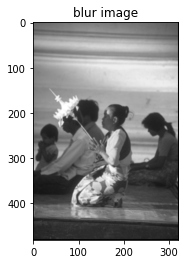

In [9]:
L = convolution2d(Gray_I, G_kernel, Pd=1, S=1)     # we are convolving image with padding of 1 and stride of 1
plt.title('blur image')                            # plot the blur image after convoving with gaussian kernel
plt.imshow(L, cmap ='gray')

In [10]:
# calculations to get the feature image 

def FeatureImage(L):
    p = 1
    q = 1
    M, N = L.shape                                # size of input image
   
    Z = np.zeros((M,N), dtype=np.int32)           # array of zeroes of input image size
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            if i==1 or j==1  or i==M-1 or j==N-1 :  # if the pixel is on the edge of the image we don't want to make any changes  
                Z[i,j] = L[i,j]                     # in those pixels

            else:                                   # for other than edge pixels we will calculate the neighbourhood e1 to e8
                e1 = abs(L[i-1,j-1] - L[i,j])
                e2 = abs(L[i-1,j] - L[i,j])
                e3 = abs(L[i-1,j+1] - L[i,j])
                e4 = abs(L[i,j-1] - L[i,j])
                e5 = abs(L[i,j+1] - L[i,j])
                e6 = abs(L[i+1,j-1] - L[i,j])
                e7 = abs(L[i+1,j] - L[i,j])
                e8 = abs(L[i+1,j+1] - L[i,j])

# after calculation of neighbourhood of the pixel we want to change pixel value in the middle according to the neighbourhood
# pixel values after the calculation of x1 to x8

                x1 = (e1**p)*(e2**q) + (e1**p)*(e3**q) + (e1**p)*(e4**q) + (e1**p)*(e5**q) + (e1**p)*(e6**q) + (e1**p)*(e7**q) + (e1**p)*(e8**q)
                x2 = (e2**p)*(e1**q) + (e2**p)*(e3**q) + (e2**p)*(e4**q) + (e2**p)*(e5**q) + (e2**p)*(e6**q) + (e2**p)*(e7**q) + (e2**p)*(e8**q)
                x3 = (e3**p)*(e1**q) + (e3**p)*(e2**q) + (e3**p)*(e4**q) + (e3**p)*(e5**q) + (e3**p)*(e6**q) + (e3**p)*(e7**q) + (e3**p)*(e8**q)
                x4 = (e4**p)*(e1**q) + (e4**p)*(e2**q) + (e4**p)*(e3**q) + (e4**p)*(e5**q) + (e4**p)*(e6**q) + (e4**p)*(e7**q) + (e4**p)*(e8**q)
                x5 = (e5**p)*(e1**q) + (e5**p)*(e2**q) + (e5**p)*(e3**q) + (e5**p)*(e4**q) + (e5**p)*(e6**q) + (e5**p)*(e7**q) + (e5**p)*(e8**q)
                x6 = (e6**p)*(e1**q) + (e6**p)*(e2**q) + (e6**p)*(e3**q) + (e6**p)*(e4**q) + (e6**p)*(e5**q) + (e6**p)*(e7**q) + (e6**p)*(e8**q)
                x7 = (e7**p)*(e1**q) + (e7**p)*(e2**q) + (e7**p)*(e3**q) + (e7**p)*(e4**q) + (e7**p)*(e5**q) + (e7**p)*(e6**q) + (e7**p)*(e8**q)
                x8 = (e8**p)*(e1**q) + (e8**p)*(e2**q) + (e8**p)*(e3**q) + (e8**p)*(e4**q) + (e8**p)*(e5**q) + (e8**p)*(e6**q) + (e8**p)*(e7**q)
  
                y = 1/(p+q)
            
                BM = ((1/56) * ((x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8)** y))  # we are calculating bonferroni mean for every 
                                                                               # pixel which is not on the edge
                
                Z[i, j] = BM   # here we are reflecting the changed values in the Z as our feature image                

    return Z

In [11]:
def FinalFeatureImage(If):
    M, N = If.shape                           # size of input image
  
    F = np.zeros((M,N), dtype=np.int32)       # size of output image       
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            
            F[i,j] = (If[i,j]) ** (0.2)       # increasing intensity of input image
  
    return F  

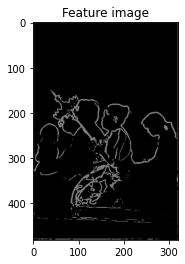

In [12]:
If = FeatureImage(L)                
plt.title('Feature image')
If = FinalFeatureImage(If)                  
plt.imshow(If,cmap='gray')                   # plot the final feature image output

(481, 321)


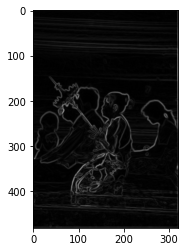

In [13]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    print(G.shape)
   
    plt.imshow(G,cmap = 'gray')
 
    return (G, theta)

Sobel, theta_canny = sobel_filters(L)

(481, 321)


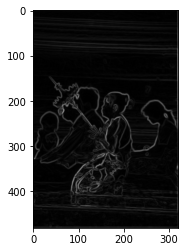

In [14]:
from scipy import ndimage

def Prewitt_filter(img):
    Kx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], np.float32)
    Ky = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    print(G.shape)
   
    plt.imshow(G,cmap = 'gray')
 
    return (G, theta)

Prewitt, theta_Prewitt = Prewitt_filter(L)

In [15]:
# calculating the phase of the the blur image

from scipy import ndimage

def ThetaCalculation(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)  # x coordinates of sobal operator
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)  # y coordinates of sobal operator
    
    Ix = ndimage.filters.convolve(img, Kx)   # convolving image with the sobel x
    Iy = ndimage.filters.convolve(img, Ky)   # convolving image with the sobel y
    
    theta = np.arctan2(Iy, Ix)               # theta calculation
    
    return theta
theta_algorithm = ThetaCalculation(L)

In [16]:
def non_max_suppression(Img, D):                    # applying non maximum supression to image to get thiner edges
    M, N = Img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi                   # angel calcuation for the pixels
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180): # here we are calculating neighbours in the +ve
                    q = Img[i, j+1]                                          # and -ve gradient direction 
                    r = Img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = Img[i+1, j-1]
                    r = Img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = Img[i+1, j]
                    r = Img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = Img[i-1, j-1]
                    r = Img[i+1, j+1]

                if (Img[i,j] >= q) and (Img[i,j] >= r):
                    Z[i,j] = Img[i,j]
                else:
                    Z[i,j] = 0                          # if magnitude of current pixel is greater than the magnitude of
                                                        # NEIGHBOURS nothing changes else magnitude of current pixel is set to 
            except IndexError as e:                     # zero.
                pass
    
    return Z

(481, 321)
(481, 321)


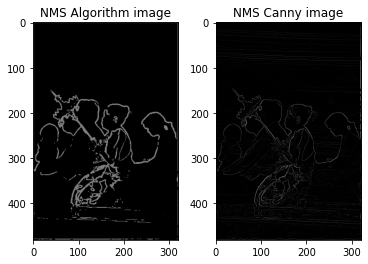

In [17]:
NMS_Algorithm = non_max_suppression(If, theta_algorithm)
plt.subplot(1,2,1)
plt.title('NMS Algorithm image')
plt.imshow(NMS_Algorithm,cmap='gray')
print(NMS_Algorithm.shape)
NMS_Canny = non_max_suppression(Sobel, theta_canny)
plt.subplot(1,2,2)
plt.title('NMS Canny image')
plt.imshow(NMS_Canny,cmap='gray')
print(NMS_Canny.shape)

In [18]:
# threshoolding is done to suppress low threshold values and mark higher threshold values

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09): # here we have set high and low threshold ratios
    
    highThreshold = img.max() * highThresholdRatio            # claculation of high threshold
    lowThreshold = highThreshold * lowThresholdRatio          # calculation of low threshold
    
    M, N = img.shape                                          # input image shape  
    Z = np.zeros((M,N), dtype=np.int32)                     # output image shape
    
    weak = np.int32(25)                                       # defining weak pixels
    strong = np.int32(255)                                    # defining strong pixels
    
    strong_i, strong_j = np.where(img >= highThreshold)       # getting strong pixels
    zeros_i, zeros_j = np.where(img < lowThreshold)           # making zero where pixel intensity is lower than low threshold
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold)) # getting the weak pixel
    
    Z[strong_i, strong_j] = strong
    Z[weak_i, weak_j] = weak
    print('weak pixel is: ',weak)
    return (Z, weak, strong)

weak pixel is:  25
weak pixel is:  25


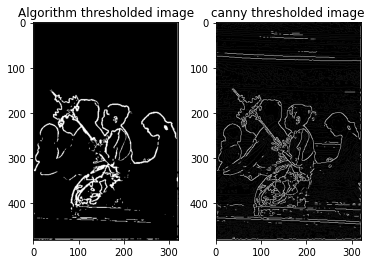

In [19]:
Z_Algorithm, weak_Algorithm, strong_Algorithm = threshold(NMS_Algorithm, lowThresholdRatio=0.05, highThresholdRatio=0.09)
plt.subplot(1,2,1)
plt.title('Algorithm thresholded image')
plt.imshow(Z_Algorithm, cmap='gray')
Z_canny, weak_canny, strong_canny = threshold(NMS_Canny, lowThresholdRatio=0.05, highThresholdRatio=0.09)
plt.subplot(1,2,2)
plt.title('canny thresholded image')
plt.imshow(Z_canny, cmap='gray')

In [20]:
# applying hystersis to thresholded image

def hysteresis(img, weak, strong=255):     # deciding on which weak pixels to be included in the final edge map
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):         # if any pixel in the neighbourhood of the pixel is strong we will consider that
                try:                       # pixel to be strong
                    
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        
                        img[i, j] = strong
                        
                    else:
                        img[i, j] = 0           # if none of the neighbourhood pixel is strong then we will consider it as weak
                                                # pixel and we will not consider it in final image 
                except IndexError as e:
                    pass
    return img

(481, 321)
(481, 321)


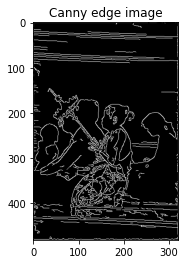

In [21]:
Final_Algorithm = hysteresis(Z_Algorithm, weak_Algorithm, strong=255)
plt.subplot(1,2,1)
plt.title('Bonferroni Mean image')                  # final output of the algorithm
plt.imshow(Final_Algorithm,cmap = 'gray')
print(Final_Algorithm.shape)

Final_Canny = hysteresis(Z_canny, weak_canny, strong=255)
#plt.subplot(1,2,1)
plt.title('Canny edge image')                  # final output of the algorithm
plt.imshow(Final_Canny,cmap = 'gray')
print(Final_Canny.shape)

In [22]:
G_truth = mpimg.imread("6046.png")
plt.imshow(G_truth,cmap='gray')
print(type(G_truth))
print(G_truth.shape)

FileNotFoundError: ignored

In [ ]:
def Confusion_mat_Parameters(Edge_img, Ground_truth) :     # deciding on which weak pixels to be included in the final edge map
    M, N = Edge_img.shape  
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(1, M-1):
        for j in range(1, N-1):
            if Edge_img[i,j] > 0 and Ground_truth[i,j] > 0 :
                TP+=1
                continue
            elif Edge_img[i,j] > 0 and Ground_truth[i,j] == 0 :
                FP+=1
                continue
            elif Edge_img[i,j] == 0 and Ground_truth[i,j] > 0 :
                FN+=1
                continue
            else:
                TN+=1
                
                
    return TP, FP, FN, TN

In [ ]:
TP_A, FP_A, FN_A, TN_A = Confusion_mat_Parameters(Final_Algorithm, G_truth)

TP_C, FP_C, FN_C, TN_C = Confusion_mat_Parameters(Final_Canny, G_truth)
TP_s, FP_s, FN_s, TN_s = Confusion_mat_Parameters(Sobel, G_truth)
TP_P, FP_P, FN_P, TN_P = Confusion_mat_Parameters(Prewitt, G_truth)
print(TP_A, FP_A, FN_A, TN_A)
print(TP_s, FP_s, FN_s, TN_s)
print(TP_P, FP_P, FN_P, TN_P)
print(TP_C, FP_C, FN_C, TN_C)

5454 9339 23112 114896
28566 124234 0 1
28566 124234 0 1
5874 12521 22692 111714


In [ ]:
def Performance_measures(TP, FP, FN, TN) :
    Accuracy = (TP+TN)*100/(TP + FP + FN + TN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_score = 2/((1/Precision)+(1/Recall))
    
    return Accuracy, Precision, Recall, F1_score

In [ ]:
Accu_Algo, Precision_Algo, Recall_Algo, F1_score_Algo = Performance_measures(TP_A, FP_A, FN_A, TN_A)
Accu_Canny, Precision_Canny, Recall_Canny, F1_score_Canny = Performance_measures(TP_C, FP_C, FN_C, TN_C)
Accu_s, Precision_s, Recall_s, F1_score_s = Performance_measures(TP_s, FP_s, FN_s, TN_s)
Accu_p, Precision_p, Recall_p, F1_score_p = Performance_measures(TP_P, FP_P, FN_P, TN_P)

print (Accu_Algo, Precision_Algo, Recall_Algo, F1_score_Algo)
print (Accu_s, Precision_s, Recall_s, F1_score_s)
print (Accu_p, Precision_p, Recall_p, F1_score_p)
print (Accu_Canny, Precision_Canny, Recall_Canny, F1_score_Canny)

78.76257354336687 0.3686878929223281 0.19092627599243855 0.25157406766761226
18.69555827514218 0.1869502617801047 1.0 0.3150094284485515
18.69555827514218 0.1869502617801047 1.0 0.3150094284485515
76.9549937500409 0.3193259037782006 0.20562906952320942 0.25016503055727096
